In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import folium
import folium.plugins as plugins
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

In [2]:
file_name = "./data/2019_vy.csv"

#get DateTime on the correct format (in accordance with excel file)
def load_file(file_name):
    df = pd.read_csv(file_name)
    
    # change date format
    df['DateTime'] = pd.TimedeltaIndex(df['DateTime'], unit='d') + dt.datetime(1899,12,30)
    
    # reformat coordinates to dot-separated floats
    df['Long'] = df['Long'].apply(lambda x: float(str(x).replace(',','.')))
    df['Lat'] = df['Lat'].apply(lambda x: float(str(x).replace(',','.')))
    
    # remove outliers
    df = df[(df['Long'] <= 11) & (df['Long'] >= 10.62)]
    # only keep trip if it has a start and an end
    df = df[df.duplicated('Trip ID', keep=False)]
    return df

In [3]:
data = load_file(file_name)
data.head()

,DateTime,Trip ID,TripStage,Long,Lat,Car ID,Trip duration (min)
0,2018-12-31 11:39:21.888,1,Start,10.73382,59.92934,V5a15A3226E5F7,1403.350000
1,2019-01-01 11:02:43.008,1,End,10.74900,59.91063,V5a15A3226E5F7,1403.350000
2,2019-01-01 08:18:08.352,2,Start,10.73561,59.93056,V5a15A3226E89D,24.716667
3,2019-01-01 08:42:50.976,2,End,10.80917,59.94132,V5a15A3226E89D,24.716667
4,2019-01-01 14:34:39.360,3,Start,10.72983,59.92513,V5a15A3226E999,1067.866667


In [4]:
data['Car ID'].nunique()


255

In [5]:
def get_start_data(df):
    return df.loc[df['TripStage'] == 'Start']

def get_end_data(df):
    return df.loc[df['TripStage'] == 'End']

In [6]:
def plot_scatter(df):
    
    #Stations in trip dataset
    m = folium.Map([59.92934, 10.73382], zoom_start=12)
    # mark each station as a point
    for index, row in df.sample(n=1000).iterrows():
        folium.CircleMarker([row['Lat'], row['Long']],
                            radius=3,
                            popup=str(row),
                            fill_color="#3db7e4", # divvy color
                           ).add_to(m)
    return m

In [7]:
def plot_heat_map(df):
    
    m = folium.Map([59.92934, 10.73382], zoom_start=12)

    # convert to (n, 2) nd-array format for heatmap
    trips = df[['Lat', 'Long']].sample(n=1000).values
    # plot heatmap
    m.add_child(plugins.HeatMap(trips, radius=15, blur=20))
    for row in centers:
        folium.CircleMarker([row[0], row[1]],
                            radius=10,
                            popup=str(row),color = "black",
                            fill_color="black",fill_opacity=0.7 # divvy color
                           ).add_to(m)
    return m

In [8]:
start_data = get_start_data(data)
end_data = get_end_data(data)

In [9]:
#plot_heat_map(start_data)
plot_scatter(end_data)

In [350]:
plot_heat_map(end_data)

In [10]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = start_data[['Lat']]
X_axis = start_data[['Long']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

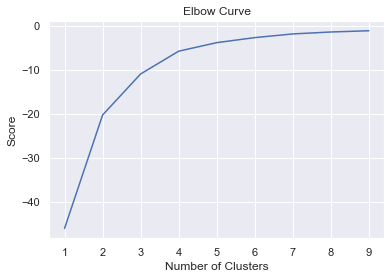

In [11]:
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()

In [12]:
X = data[:1000].copy()

kmeans = KMeans(n_clusters = 12, init ='k-means++')
kmeans.fit(X[['Lat', 'Long']]) # Compute k-means clustering. # Compute k-means clustering.

X['cluster_label'] = kmeans.fit_predict(X[['Lat', 'Long']])

centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
print(centers)

labels = kmeans.predict(X[['Lat', 'Long']]) # Labels of each point

X.head()

[[59.92109814 10.75313785]
 [59.92821217 10.67773232]
 [59.94156972 10.81300694]
 [59.91468422 10.71654   ]
 [59.94424905 10.77183524]
 [59.87966321 10.79319571]
 [59.90790333 10.63188933]
 [59.91474231 10.7713638 ]
 [59.92561193 10.73555535]
 [59.93460196 10.71613766]
 [59.90612757 10.795246  ]
 [59.9568725  10.74710525]]


,DateTime,Trip ID,TripStage,Long,Lat,Car ID,Trip duration (min),cluster_label
0,2018-12-31 11:39:21.888,1,Start,10.73382,59.92934,V5a15A3226E5F7,1403.350000,8
1,2019-01-01 11:02:43.008,1,End,10.74900,59.91063,V5a15A3226E5F7,1403.350000,0
2,2019-01-01 08:18:08.352,2,Start,10.73561,59.93056,V5a15A3226E89D,24.716667,8
3,2019-01-01 08:42:50.976,2,End,10.80917,59.94132,V5a15A3226E89D,24.716667,2
4,2019-01-01 14:34:39.360,3,Start,10.72983,59.92513,V5a15A3226E999,1067.866667,8


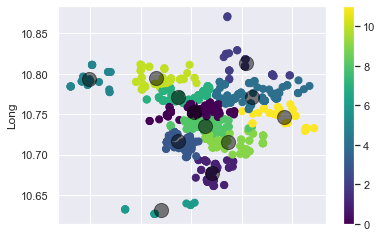

In [13]:
X.plot.scatter(x = 'Lat', y = 'Long', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)